In [1]:
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import BSpline, splev, interp1d
plt.rcParams['font.size'] = 12.0

In [ ]:
start = timeit.default_timer()

H0 = 2.268543540763823e-18   # Hubble's constant: [(km/s)/Mpc]
c  = 2.99792458e8            # Speed of light: [m/s]
Ωb = 0.046                   # Baryonic density parameter
Ωm = 0.224                   # Dark matter density parameter
Ωr = 8.3e-5                  # Radiation density parameter
ΩΛ = 1.0 - Ωb - Ωm - Ωr      # Dark energy density parameter
m2Mpc = 3.24078e-23          # Converts meters to Mpc
k = 3                       # Spline order

def geth(x):
    """Computes the Hubble parameter H given some x"""
    return H0*math.sqrt((Ωb + Ωm)*math.exp(-3.0*x) + Ωr*math.exp(-4.0*x) + ΩΛ)

def gethp(x):
    """Function for H prime e.g. H' = aH"""
    return H0*math.sqrt((Ωb + Ωm)*math.exp(-x) + Ωr*math.exp(-2.0*x) + ΩΛ*math.exp(2.0*x))

def ηder(t, x):
    """Called by odeint when solving for the conformal time eta"""
    return c/gethp(x)

def getη(x):
    """Interpolates a value from the differential equation
     solution η using values from the xη array"""
    return η2(x)

def getΩb(x):
    """Computes the value of the baryon density parameter (omega_b) at some x"""
    return Ωb*math.exp(-3.0*x)*((H0/geth(x))**2.0)

def getΩm(x):
    """Computes the dark matter density parameter (omega_m) at x"""
    return Ωm*math.exp(-3.0*x)*((H0/geth(x))**2.0)

def getΩr(x):
    """Computes radiation density (omega_r) at x"""
    return Ωr*math.exp(-4.0*x)*((H0/geth(x))**2.0)

def getΩΛ(x):
    """Computes the dark energy parameter (omega_lambda) at x;
     it is the difference between 1 and the sum of the other parameters"""
    return 1.0 - (getΩb(x) + getΩm(x) + getΩr(x))

In [2]:
nduring = 200                     # Number of grid points during recombination
nafter = 300                     # Number of grid points after recombination
ntotal = nduring + nafter        # Total number of grid points
zstart = 1630.4                  # Redshift value of when recombination starts
zend = 614.2                   # Redshift value of when recombination ends
z0 = 0.0                     # Redshift value today

xstart = -math.log(1.0 + zstart) # X value at start of recombination
xend = -math.log(1.0 + zend)   # X value at end of recombination
x0 = 0.0                     # X value today

nη = 1000                    # Number of grid points for conformal time η
a0 = 1.0e-10                 # Start value of a for η (the conformal time)
xη1 = math.log(a0)            # Start value of x for η
xη2 = 0.0                     # End   value of x for η

# Number of step values in each grid
step  = (xend - xstart)/nduring
step2 = (x0 - xend)/(nafter - 1)
step3 = (xη2 - xη1)/nη

xgrid = np.arange(xstart, xend, step)                  # Grid During recombination
xgrid = np.append(xgrid, np.arange(xend, x0, step2))   # Append grid after recombination
xgrid = np.append(xgrid, x0)
xa = [math.exp(xgrid[i]) for i in range(len(xgrid))]   # Calculate grid of a values

xη  = np.arange(xη1, xη2, step3)                       # Make grid of x values for conformal time

In [3]:
# This part solves the differential equation
η0 = c*a0/(H0*math.sqrt(Ωr))    # Intial value of eta
η  = odeint(ηder, η0, xη)             # odeint(derivative, initial value, time span)

#This part creates a spline
η2 = BSpline(xη, η, k)   # BSpline(x, y, order)

In [ ]:
# Initialize all arrays
ηspl = np.zeros(ntotal)
hxt  = np.zeros(ntotal)
Ωbxt = np.zeros(ntotal)
Ωmxt = np.zeros(ntotal)
Ωrxt = np.zeros(ntotal)
ΩΛxt = np.zeros(ntotal)

# Iterate through each array using the values from x_grid
for i in range(len(xgrid)):
    ηspl[i] = getη(xgrid[i])*m2Mpc
    hxt[i]  = geth(xgrid[i])
    Ωbxt[i] = getΩb(xgrid[i])
    Ωmxt[i] = getΩm(xgrid[i])
    Ωrxt[i] = getΩr(xgrid[i])
    ΩΛxt[i] = getΩΛ(xgrid[i])


-----------------------------------------------
------- Milestone 1 loaded successfully -------

Milestone 1 Runtime:  2878.4456883
-----------------------------------------------



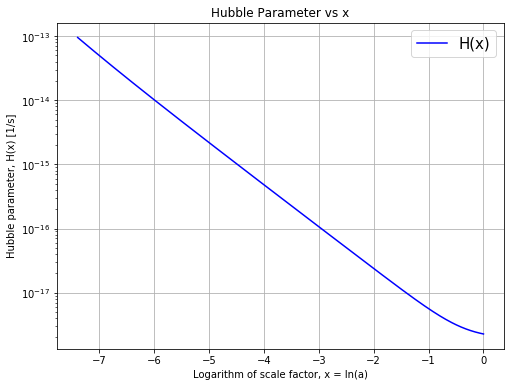

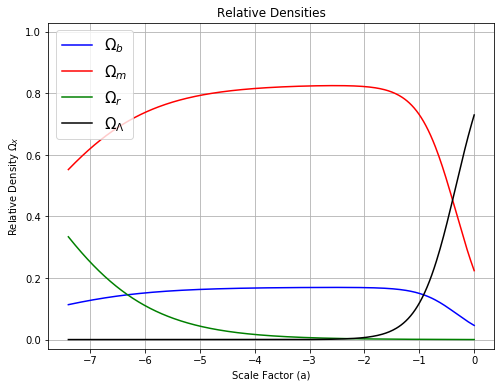

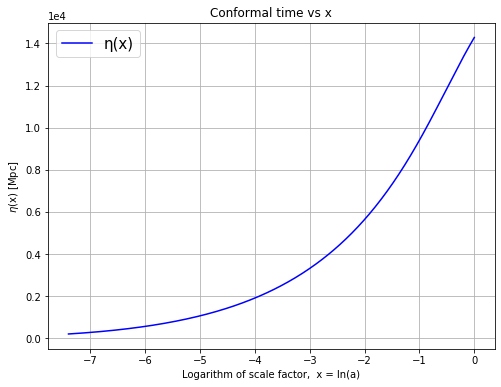

In [8]:
print("")
print("-----------------------------------------------")
print("------- Milestone 1 loaded successfully -------")
stop = timeit.default_timer()
print("")
print('Milestone 1 Runtime: ', stop - start)
print("-----------------------------------------------")
print("")

# Plot Hubble parameter
plt.figure(figsize=(8, 6))
plt.title('Hubble Parameter vs x')
plt.xlabel('Logarithm of scale factor, x = ln(a)')
plt.ylabel('Hubble parameter, H(x) [1/s]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.plot(xgrid, hxt, 'b', label='H(x)')
plt.legend(loc='best', prop={'size':15})
plt.grid()
plt.yscale('log')
#plt.savefig('Hx.png')

# Plot relative densities
plt.figure(figsize=(8, 6))
plt.title('Relative Densities')
plt.xlabel('Scale Factor (a)')
plt.ylabel('Relative Density $\Omega_X$')
plt.ylim(-.03, 1.03)
plt.plot(xgrid, Ωbxt, color='blue')
plt.plot(xgrid, Ωmxt, color='red')
plt.plot(xgrid, Ωrxt, color='green')
plt.plot(xgrid, ΩΛxt, color='black')
plt.legend(['$\Omega_b$', '$\Omega_m$', '$\Omega_r$', '$\Omega_\Lambda$'], loc='upper left', prop={'size':15})
plt.grid()
#plt.savefig('densities.png')

# Plot η
plt.figure(figsize=(8, 6))
plt.title('Conformal time vs x')
plt.xlabel('Logarithm of scale factor,  x = ln(a)')
plt.ylabel("$\eta$(x) [Mpc]")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.plot(xgrid, ηspl, 'b', label='η(x)')
plt.legend(loc='best', prop={'size':15})
plt.grid()
#plt.yscale('log')
#plt.savefig('eta.png')